In [97]:
!pip install -q kaggle

In [98]:
!pip install -q kaggle meteostat pandas pytz

In [99]:
import os
os.environ['KAGGLE_USERNAME'] = "deolelavanya"
os.environ['KAGGLE_KEY'] = "991be3bf86ac311d8810564300c993c6"


In [100]:
!mkdir -p data
!kaggle datasets download -d gabrielluizone/us-domestic-flights-delay-prediction-2013-2018 \
    -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/gabrielluizone/us-domestic-flights-delay-prediction-2013-2018
License(s): CC0-1.0


In [101]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, concat_ws, when



spark = SparkSession.builder \
    .appName("FlightDelay_EDA") \
    .getOrCreate()


df = spark.read.csv("data/*.csv", header=True, inferSchema=True)


df.show(5, truncate=False)
df.printSchema()

+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+--------+---------------+-------+
|is_delay|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Reporting_Airline|Origin|OriginState|Dest|DestState|CRSDepTime|Cancelled|Diverted|Distance|DistanceGroup|ArrDelay|ArrDelayMinutes|AirTime|
+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+--------+---------------+-------+
|1.0     |2014|1      |1    |1         |3        |2014-01-01|UA               |LAX   |CA         |ORD |IL       |900       |0.0      |0.0     |1744.0  |7            |43.0    |43.0           |218.0  |
|0.0     |2014|1      |1    |1         |3        |2014-01-01|AA               |IAH   |TX         |DFW |TX       |1750      |0.0      |0.0     |224.0   |1            |2.0     |2.0            |50.0   |


# EDA

In [102]:
df.printSchema()
print(df.columns)

root
 |-- is_delay: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DistanceGroup: integer (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)

['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime', 'Cancell

In [103]:
# Clean & preprocess into cleaned
from pyspark.sql.functions import col, to_date, when

cleaned = (
    df

    .filter((col("Cancelled") == 0) & (col("Diverted") == 0))


    .withColumn("FL_DATE", to_date(col("FlightDate"), "yyyy-MM-dd"))


    .withColumn("DepHour", (col("CRSDepTime") / 100).cast("integer"))


    .dropna(subset=["ArrDelay", "CRSDepTime"])


    .withColumn(
        "ArrDelayCap",
        when(col("ArrDelay") > 500, 500)
         .when(col("ArrDelay") < -60, -60)
         .otherwise(col("ArrDelay"))
    )


    .dropDuplicates()
)


cleaned.createOrReplaceTempView("clean_flights")
cleaned.select("FL_DATE","Reporting_Airline","Origin","Dest","DepHour","ArrDelay","ArrDelayCap") \
       .show(5, truncate=False)

+----------+-----------------+------+----+-------+--------+-----------+
|FL_DATE   |Reporting_Airline|Origin|Dest|DepHour|ArrDelay|ArrDelayCap|
+----------+-----------------+------+----+-------+--------+-----------+
|2014-01-01|WN               |DEN   |PHX |16     |85.0    |85.0       |
|2014-01-01|WN               |LAX   |SFO |15     |17.0    |17.0       |
|2014-01-01|DL               |LAX   |ATL |6      |-13.0   |-13.0      |
|2014-01-01|AA               |IAH   |DFW |16     |28.0    |28.0       |
|2014-01-01|AA               |ORD   |DFW |14     |126.0   |126.0      |
+----------+-----------------+------+----+-------+--------+-----------+
only showing top 5 rows



In [104]:
from pyspark.sql.functions import col, count, when


print("Rows:", cleaned.count())
print("Columns:", cleaned.columns)


cleaned.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in cleaned.columns
]).show(truncate=False)

Rows: 1635587
Columns: ['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState', 'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup', 'ArrDelay', 'ArrDelayMinutes', 'AirTime', 'FL_DATE', 'DepHour', 'ArrDelayCap']
+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+--------+---------------+-------+-------+-------+-----------+
|is_delay|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Reporting_Airline|Origin|OriginState|Dest|DestState|CRSDepTime|Cancelled|Diverted|Distance|DistanceGroup|ArrDelay|ArrDelayMinutes|AirTime|FL_DATE|DepHour|ArrDelayCap|
+--------+----+-------+-----+----------+---------+----------+-----------------+------+-----------+----+---------+----------+---------+--------+--------+-------------+--------+---------------+-------+-------+-------+----------

In [105]:

cleaned.describe("ArrDelayCap", "Distance", "DepHour").show()

+-------+-----------------+------------------+------------------+
|summary|      ArrDelayCap|          Distance|           DepHour|
+-------+-----------------+------------------+------------------+
|  count|          1635587|           1635587|           1635587|
|   mean|5.855344289236831|1011.3977287664918|12.871023063890823|
| stddev|40.14847115614445| 538.1233711828634| 4.974136047440398|
|    min|            -60.0|             224.0|                 0|
|    max|            500.0|            2296.0|                23|
+-------+-----------------+------------------+------------------+



In [106]:
from pyspark.sql.functions import avg, round

# average delay by airline
cleaned.groupBy("Reporting_Airline") \
       .agg(
           round(avg("ArrDelayCap"),1).alias("avg_delay"),
           count("*").alias("flight_count")
       ) \
       .filter(col("flight_count") >= 100000) \
       .orderBy(col("avg_delay").desc()) \
       .show(10)

+-----------------+---------+------------+
|Reporting_Airline|avg_delay|flight_count|
+-----------------+---------+------------+
|               WN|     10.1|      181439|
|               UA|      5.7|      492840|
|               AA|      5.7|      593362|
|               DL|      2.1|      270148|
+-----------------+---------+------------+



In [107]:
# Monthly
cleaned.groupBy("Month") \
       .agg(round(avg("ArrDelayCap"),1).alias("avg_delay")) \
       .orderBy("Month") \
       .show()


cleaned.groupBy("DayOfWeek") \
       .agg(round(avg("ArrDelayCap"),1).alias("avg_delay")) \
       .orderBy("DayOfWeek") \
       .show()


cleaned.groupBy("DepHour") \
       .agg(round(avg("ArrDelayCap"),1).alias("avg_delay")) \
       .orderBy("DepHour") \
       .show()

+-----+---------+
|Month|avg_delay|
+-----+---------+
|    1|      5.0|
|    2|      4.0|
|    3|      4.8|
|    4|      4.3|
|    5|      7.2|
|    6|     11.3|
|    7|      9.4|
|    8|      9.3|
|    9|      1.9|
|   10|      3.4|
|   11|      1.9|
|   12|      7.0|
+-----+---------+

+---------+---------+
|DayOfWeek|avg_delay|
+---------+---------+
|        1|      7.6|
|        2|      4.0|
|        3|      5.3|
|        4|      7.8|
|        5|      7.8|
|        6|      2.0|
|        7|      5.7|
+---------+---------+

+-------+---------+
|DepHour|avg_delay|
+-------+---------+
|      0|     -1.2|
|      1|     -2.7|
|      2|      4.3|
|      4|    -10.4|
|      5|     -4.8|
|      6|     -3.7|
|      7|     -0.4|
|      8|      1.8|
|      9|      2.9|
|     10|      4.9|
|     11|      4.9|
|     12|      5.9|
|     13|      6.7|
|     14|      7.7|
|     15|      9.0|
|     16|      9.9|
|     17|     10.4|
|     18|     12.2|
|     19|     12.2|
|     20|     13.5|
+-------

In [108]:

cleaned.groupBy("Origin","Dest") \
       .agg(
         round(avg("ArrDelayCap"),1).alias("avg_delay"),
         count("*").alias("n")
       ) \
       .filter(col("n") >= 50000) \
       .orderBy(col("avg_delay").desc()) \
       .limit(10) \
       .show(truncate=False)

+------+----+---------+-----+
|Origin|Dest|avg_delay|n    |
+------+----+---------+-----+
|LAX   |SFO |12.4     |56881|
|SFO   |LAX |12.1     |57807|
+------+----+---------+-----+



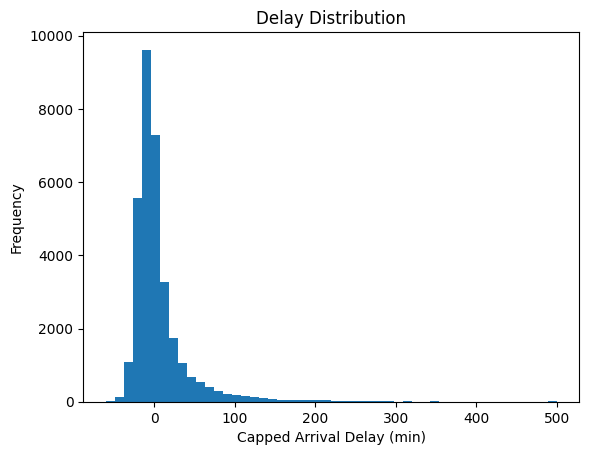

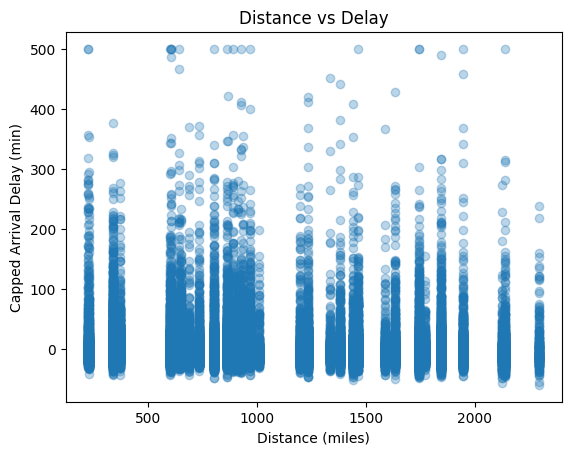

In [109]:
import matplotlib.pyplot as plt


pdf = cleaned.sample(False, 0.02, seed=42).toPandas()


plt.hist(pdf["ArrDelayCap"], bins=50)
plt.xlabel("Capped Arrival Delay (min)")
plt.ylabel("Frequency")
plt.title("Delay Distribution")
plt.show()


plt.scatter(pdf["Distance"], pdf["ArrDelayCap"], alpha=0.3)
plt.xlabel("Distance (miles)")
plt.ylabel("Capped Arrival Delay (min)")
plt.title("Distance vs Delay")
plt.show()

In [110]:
from pyspark.sql.functions import year


df_ml = cleaned.filter(year(col("FL_DATE")).between(2013, 2018))


sample_pdf = df_ml.select("FL_DATE", "Origin", "DepHour") \
                  .distinct() \
                  .sample(False, 0.02, seed=42) \
                  .toPandas()


# ADD WEATHER FOR BETTER PERFOMANCE

In [111]:
from meteostat import Stations, Daily
from datetime import datetime
from geopy.geocoders import Nominatim
import pandas as pd
import time

airport_codes = ["PHX", "DEN", "LAX", "ATL", "ORD", "DFW", "SFO", "IAH", "CLT"]
geolocator = Nominatim(user_agent="weather-delay-predictor", timeout=10)
airport_to_weather = {}
weather_rows = []


sample_pdf["FL_DATE"] = pd.to_datetime(sample_pdf["FL_DATE"]).dt.date


start = datetime(2013, 1, 1)
end = datetime(2018, 12, 31)

for code in airport_codes:
    try:
        location = geolocator.geocode(code + " airport")
        if location:
            lat, lon = location.latitude, location.longitude

            stations = Stations().nearby(lat, lon).fetch(3)
            #print(f"Stations for {code}:\n", stations.head())

            if not stations.empty:
                station_id = stations.index[0]  # << FIX: use index, not column
                airport_to_weather[code] = station_id

                weather_df = Daily(station_id, start, end).fetch()
                if not weather_df.empty:
                    weather_df = weather_df.reset_index()
                    weather_df["AIRPORT"] = code
                    weather_rows.append(weather_df)

        time.sleep(1)

    except Exception as e:
        print(f" Failed for {code}: {e}")

if weather_rows:
    weather_data = pd.concat(weather_rows)
    weather_data["FL_DATE"] = weather_data["time"].dt.date
    weather_data = weather_data[["FL_DATE", "AIRPORT", "tavg", "prcp", "wspd", "pres"]]
    #print("✅ Weather data shape:", weather_data.shape)
else:
    print(" No weather data fetched.")


weather_rows = []

for code, station_id in airport_to_weather.items():

    start = pd.to_datetime(sample_pdf[sample_pdf["Origin"] == code]["FL_DATE"].min())
    end = pd.to_datetime(sample_pdf[sample_pdf["Origin"] == code]["FL_DATE"].max())

    weather_df = Daily(station_id, start, end).fetch()
    if not weather_df.empty:
        weather_df = weather_df.reset_index()
        weather_df["AIRPORT"] = code
        weather_df["FL_DATE"] = weather_df["time"].dt.date
        weather_rows.append(weather_df)

weather_data = pd.concat(weather_rows)
weather_data = weather_data[["FL_DATE", "AIRPORT", "tavg", "prcp", "wspd", "pres"]]
weather_data.columns = ["FL_DATE", "Origin", "TEMP", "PRECIP", "WIND", "PRESSURE"]


weather_spark = spark.createDataFrame(weather_data)
df_joined = df_ml.join(weather_spark, on=["FL_DATE", "Origin"], how="left")


In [112]:
from pyspark.sql.functions import col, to_date, when, year
import matplotlib.pyplot as plt
import pandas as pd

# CLASSIFICATION MODELS

In [113]:
from pyspark.sql.functions import col, to_date, when, year
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np

In [114]:
# Select features & label
label_col = "ArrDelayCap"
numeric_cols = ["DepHour", "Distance"]
cat_cols = ["Reporting_Airline", "Origin", "Dest", "DayOfWeek", "Month"]

#One-hot encode categoricals in Pandas
pdf_cat = pd.get_dummies(pdf[cat_cols].astype(str), prefix=cat_cols)
X = pd.concat([pdf[numeric_cols], pdf_cat], axis=1)
y = pdf[label_col]   #  Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [115]:
rf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [116]:
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)

In [117]:
gbt = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42)
gbt.fit(X_train, y_train)
pred_gbt = gbt.predict(X_test)


In [118]:
#RMSE CALCULATIONS
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
rmse_gbt = np.sqrt(mean_squared_error(y_test, pred_gbt))

print(f"RF   RMSE = {rmse_rf:.2f}")
print(f"XGB  RMSE = {rmse_xgb:.2f}")
print(f"GBT  RMSE = {rmse_gbt:.2f}")

RF   RMSE = 37.68
XGB  RMSE = 37.89
GBT  RMSE = 37.52


In [119]:
threshold = 15

In [120]:
y_test_binary = (y_test > threshold).astype(int)
pred_rf_binary = (pred_rf > threshold).astype(int)
pred_xgb_binary = (pred_xgb > threshold).astype(int)
pred_gbt_binary = (pred_gbt > threshold).astype(int)

# Calculate accuracy
acc_rf = accuracy_score(y_test_binary, pred_rf_binary)
acc_xgb = accuracy_score(y_test_binary, pred_xgb_binary)
acc_gbt = accuracy_score(y_test_binary, pred_gbt_binary)

print(f"RF   Accuracy = {acc_rf:.2f}")
print(f"XGB  Accuracy = {acc_xgb:.2f}")
print(f"GBT  Accuracy = {acc_gbt:.2f}")


RF   Accuracy = 0.77
XGB  Accuracy = 0.74
GBT  Accuracy = 0.76


In [121]:
conf_matrix_rf = confusion_matrix(y_test_binary, pred_rf_binary)
conf_matrix_xgb = confusion_matrix(y_test_binary, pred_xgb_binary)
conf_matrix_gbt = confusion_matrix(y_test_binary, pred_gbt_binary)

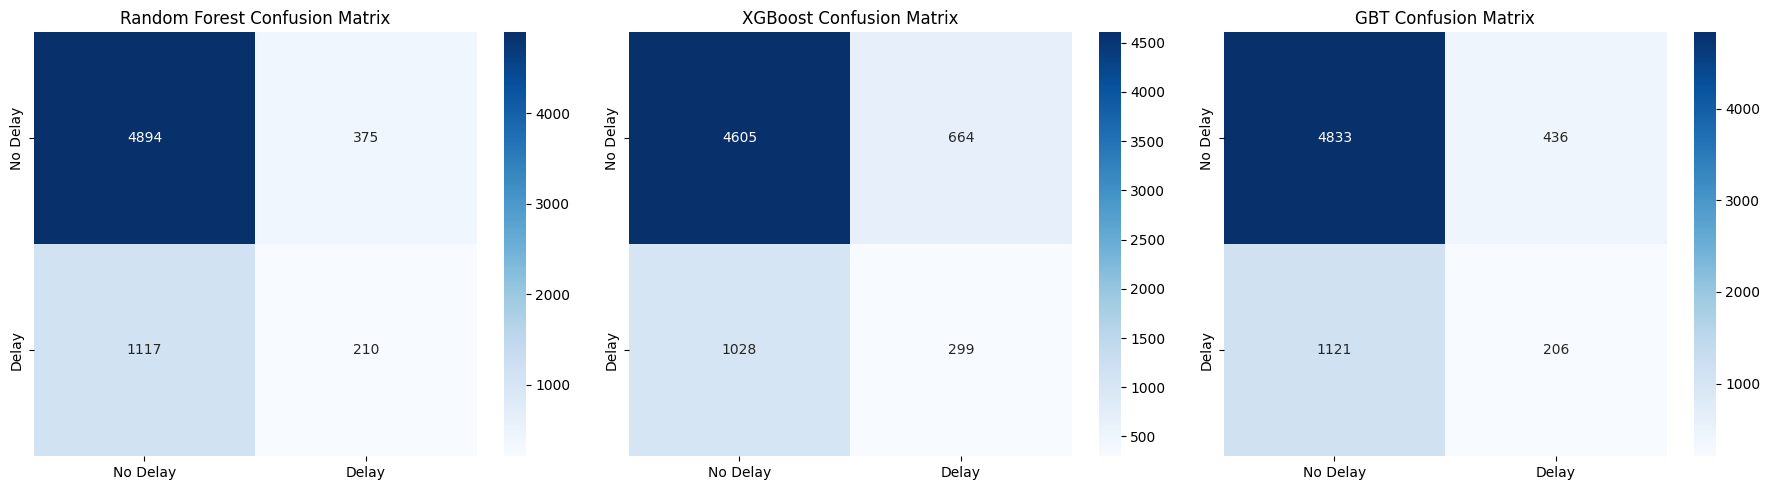

In [122]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=["No Delay", "Delay"], yticklabels=["No Delay", "Delay"])
axes[0].set_title("Random Forest Confusion Matrix")

sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=["No Delay", "Delay"], yticklabels=["No Delay", "Delay"])
axes[1].set_title("XGBoost Confusion Matrix")

sns.heatmap(conf_matrix_gbt, annot=True, fmt="d", cmap="Blues", ax=axes[2],
            xticklabels=["No Delay", "Delay"], yticklabels=["No Delay", "Delay"])
axes[2].set_title("GBT Confusion Matrix")

plt.tight_layout()
plt.show()

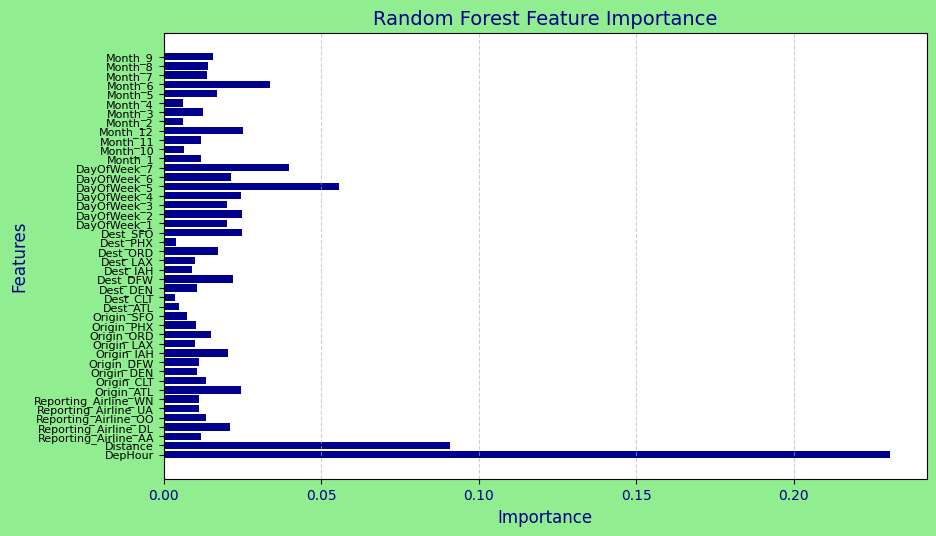

In [123]:
import matplotlib.pyplot as plt

# Random Forest Feature Importance
rf_importance = rf.feature_importances_


plt.figure(figsize=(10, 6))
plt.barh(X.columns, rf_importance, color='darkblue')
plt.title("Random Forest Feature Importance", fontsize=14, color='darkblue')
plt.xlabel('Importance', fontsize=12, color='darkblue')
plt.ylabel('Features', fontsize=12, color='darkblue')


plt.gcf().set_facecolor('lightgreen')


plt.tick_params(axis='y', labelsize=8, labelcolor='black')
plt.tick_params(axis='x', labelsize=10, labelcolor='darkblue')


plt.grid(axis='x', linestyle='--', alpha=0.6)


plt.tight_layout(pad=3.0)

plt.show()


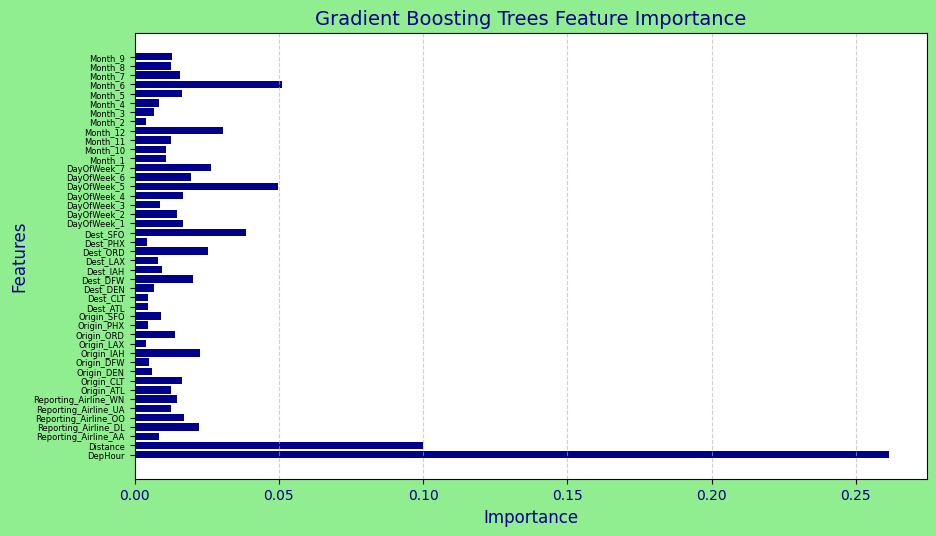

In [124]:
# Gradient Boosting Trees Feature Importance
gbt_importance = gbt.feature_importances_


plt.figure(figsize=(10, 6))
plt.barh(X.columns, gbt_importance, color='darkblue')
plt.title("Gradient Boosting Trees Feature Importance", fontsize=14, color='darkblue')
plt.xlabel('Importance', fontsize=12, color='darkblue')
plt.ylabel('Features', fontsize=12, color='darkblue')


plt.gcf().set_facecolor('lightgreen')


plt.tick_params(axis='y', labelsize=6, labelcolor='black')
plt.tick_params(axis='x', labelsize=10, labelcolor='darkblue')


plt.grid(axis='x', linestyle='--', alpha=0.6)


plt.tight_layout(pad=3.0)

plt.show()


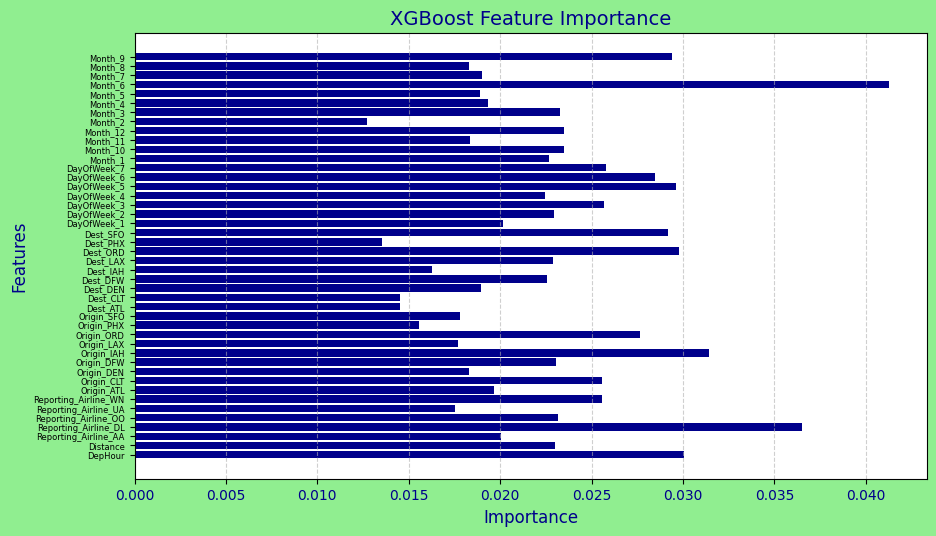

In [125]:
# XGBoost Feature Importance
xgb_importance = xgb_model.feature_importances_

# Plotting XGBoost Feature Importance with a light green background and dark blue bars
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb_importance, color='darkblue')  # Dark blue bars
plt.title("XGBoost Feature Importance", fontsize=14, color='darkblue')
plt.xlabel('Importance', fontsize=12, color='darkblue')
plt.ylabel('Features', fontsize=12, color='darkblue')


plt.gcf().set_facecolor('lightgreen')


plt.tick_params(axis='y', labelsize=6, labelcolor='black')
plt.tick_params(axis='x', labelsize=10, labelcolor='darkblue')


plt.grid(axis='x', linestyle='--', alpha=0.6)


plt.tight_layout(pad=3.0)

plt.show()


# FINAL MODEL CHOSEN : Ensemble

In [126]:

ensemble_pred = (pred_rf + pred_xgb + pred_gbt) / 3


rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_pred))
print(f"Ensemble RMSE = {rmse_ensemble:.2f}")

ensemble_pred_binary = (ensemble_pred > threshold).astype(int)


acc_ensemble = accuracy_score(y_test_binary, ensemble_pred_binary)
print(f"Ensemble Accuracy = {acc_ensemble:.2f}")


Ensemble RMSE = 37.56
Ensemble Accuracy = 0.76
